# **#特徴量の炙り出し**

                    Feature  Importance
8              max_humidity    0.150127
2           max_temperature    0.097609
21         wind_dir_degrees    0.068688
17           max_wind_Speed    0.055779
12  mean_sea_level_pressure    0.055498
11   max_sea_level_pressure    0.054518
7             min_dew_point    0.054062
16           min_visibility    0.050756
4           min_temperature    0.049044
9             mean_humidity    0.044726
6            mean_dew_point    0.043675
18          mean_wind_speed    0.040399
10             min_humidity    0.037783
1                end_number    0.033737
0              start_number    0.030431
20              cloud_cover    0.027420
13   min_sea_level_pressure    0.026939
5             max_dew_point    0.026337
3          mean_temperature    0.020501
15          mean_visibility    0.016159
19            precipitation    0.013688
14           max_visibility    0.002124


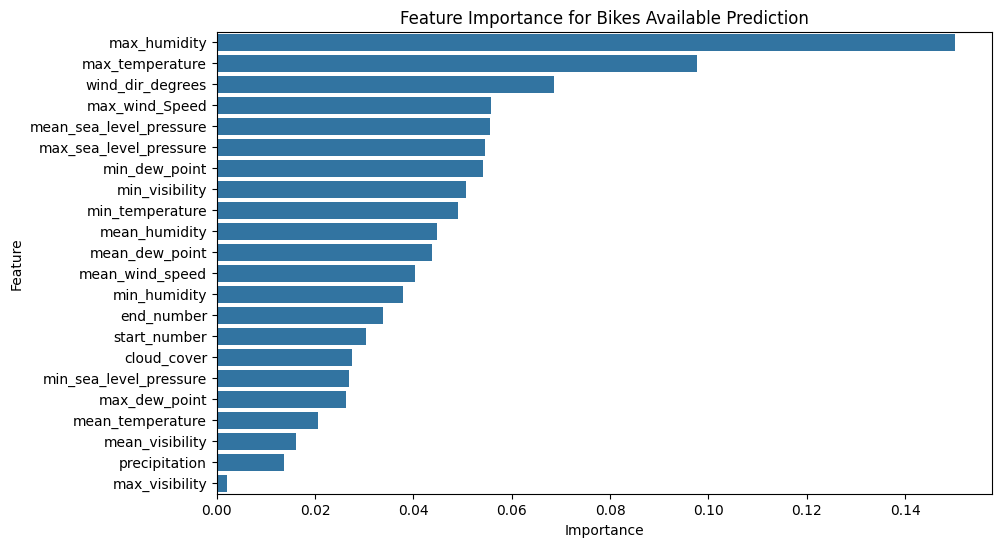

RMSE: 3.689849067357551


/tmp/ipykernel_99414/2411850077.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_bikes_available'] = model.predict(X_test_predict)
/tmp/ipykernel_99414/2411850077.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_bikes_available'] = test_data['predicted_bikes_available'].round().astype(int)


        id  predicted_bikes_available
8761  8761                          9
8762  8762                          9
8763  8763                          9
8764  8764                          9
8765  8765                          9


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Step 1: データを読み込む
status_data = pd.read_csv('/home-asustor/teramoto/SIGNATE/SOTA_Challenge/Share_Cycle/data/status.csv')
trip_data = pd.read_csv('/home-asustor/teramoto/SIGNATE/SOTA_Challenge/Share_Cycle/data/trip.csv')
weather_data = pd.read_csv('/home-asustor/teramoto/SIGNATE/SOTA_Challenge/Share_Cycle/data/weather.csv')

# Step 2: 必要なカラムの抽出と処理
# 天気データの日付と時間を抽出
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data['year'] = weather_data['date'].dt.year
weather_data['month'] = weather_data['date'].dt.month
weather_data['day'] = weather_data['date'].dt.day

# trip_data の特徴量を作成
trip_data['start_date'] = pd.to_datetime(trip_data['start_date'])
trip_data['year'] = trip_data['start_date'].dt.year
trip_data['month'] = trip_data['start_date'].dt.month
trip_data['day'] = trip_data['start_date'].dt.day
trip_data['hour'] = trip_data['start_date'].dt.hour

# 出発数と到着数のカウント
start_count = trip_data.groupby(['year', 'month', 'day', 'hour', 'start_station_id']).size().reset_index(name='start_number')
end_count = trip_data.groupby(['year', 'month', 'day', 'hour', 'end_station_id']).size().reset_index(name='end_number')

# Step 3: データのマージ
# status_data と weather_data のマージ
merged_data = pd.merge(status_data, weather_data, on=['year', 'month', 'day'], how='left')

# start_count と end_count を merged_data にマージ
merged_data = pd.merge(merged_data, start_count, left_on=['year', 'month', 'day', 'hour', 'station_id'], right_on=['year', 'month', 'day', 'hour', 'start_station_id'], how='left')
merged_data = pd.merge(merged_data, end_count, left_on=['year', 'month', 'day', 'hour', 'station_id'], right_on=['year', 'month', 'day', 'hour', 'end_station_id'], how='left')

# 欠損値を0で埋める
merged_data.fillna(0, inplace=True)

# Step 4: モデル訓練のためのデータ作成
# predict が 0 のデータを使って学習データを作成
train_data = merged_data[merged_data['predict'] == 0]

# 使用する特徴量
features = ['start_number', 'end_number', 'max_temperature', 'mean_temperature', 'min_temperature', 'max_dew_point', 'mean_dew_point', 'min_dew_point', 'max_humidity', 'mean_humidity', 'min_humidity', 'max_sea_level_pressure', 'mean_sea_level_pressure', 'min_sea_level_pressure', 'max_visibility', 'mean_visibility', 'min_visibility', 'max_wind_Speed', 'mean_wind_speed', 'precipitation', 'cloud_cover', 'wind_dir_degrees']

# 入力データとターゲットを分ける
X = train_data[features]
y = train_data['bikes_available']

# Step 5: モデルの訓練
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 6: 特徴量の重要度の計算
feature_importances = model.feature_importances_

# 特徴量と重要度をデータフレームにまとめる
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# 重要度でソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 7: 結果の表示
print(importance_df)

# Step 8: 特徴量の重要度を可視化
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Bikes Available Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Step 5: モデルの訓練
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# モデルの評価
y_pred = model.predict(X_test)
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

# Step 6: 予測の実行
# predict が 1 のデータに対して bikes_available を予測
test_data = merged_data[merged_data['predict'] == 1]
X_test_predict = test_data[features]

test_data['predicted_bikes_available'] = model.predict(X_test_predict)

# Step 7: predicted_bikes_available を整数に変換
test_data['predicted_bikes_available'] = test_data['predicted_bikes_available'].round().astype(int)

# Step 8: id と predicted_bikes_available のみを保存、ヘッダーなし
output_data = test_data[['id', 'predicted_bikes_available']]
output_data.to_csv('/home-asustor/teramoto/SIGNATE/SOTA_Challenge/Share_Cycle/data/predicted_bikes_available.csv', index=False, header=False)

# 保存後の確認（最初の数行を表示）
print(output_data.head())

# **#精度の向上（特徴量の削減とチューニング）**

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.1min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.1min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.2min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.2min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.1min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 5.1min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 2.5min
[CV] END max_depth=10, min_s

/home-asustor/teramoto/.conda/envs/detectron2/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 3.7min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 3.9min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 7.7min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 7.9min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 8.9min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=11.9min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=11.6min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 3.0min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 3.9min
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total t

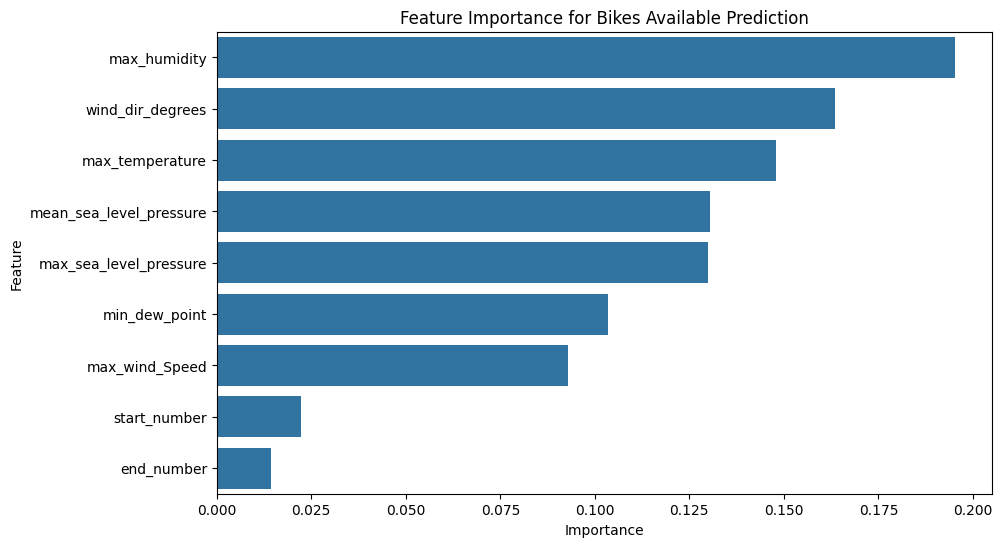

RMSE: 3.6381207254388728
        id  predicted_bikes_available
8761  8761                          9
8762  8762                          9
8763  8763                          9
8764  8764                          9
8765  8765                          9


/tmp/ipykernel_4066/4086549392.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_bikes_available'] = best_model.predict(X_test_predict)
/tmp/ipykernel_4066/4086549392.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_bikes_available'] = test_data['predicted_bikes_available'].round().astype(int)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Step 1: データを読み込む
status_data = pd.read_csv('/home-asustor/teramoto/SIGNATE/SOTA_Challenge/Share_Cycle/data/status.csv')
trip_data = pd.read_csv('/home-asustor/teramoto/SIGNATE/SOTA_Challenge/Share_Cycle/data/trip.csv')
weather_data = pd.read_csv('/home-asustor/teramoto/SIGNATE/SOTA_Challenge/Share_Cycle/data/weather.csv')

# Step 2: 必要なカラムの抽出と処理
# 天気データの日付と時間を抽出
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data['year'] = weather_data['date'].dt.year
weather_data['month'] = weather_data['date'].dt.month
weather_data['day'] = weather_data['date'].dt.day

# trip_data の特徴量を作成
trip_data['start_date'] = pd.to_datetime(trip_data['start_date'])
trip_data['year'] = trip_data['start_date'].dt.year
trip_data['month'] = trip_data['start_date'].dt.month
trip_data['day'] = trip_data['start_date'].dt.day
trip_data['hour'] = trip_data['start_date'].dt.hour

# 出発数と到着数のカウント
start_count = trip_data.groupby(['year', 'month', 'day', 'hour', 'start_station_id']).size().reset_index(name='start_number')
end_count = trip_data.groupby(['year', 'month', 'day', 'hour', 'end_station_id']).size().reset_index(name='end_number')

# Step 3: データのマージ
# status_data と weather_data のマージ
merged_data = pd.merge(status_data, weather_data, on=['year', 'month', 'day'], how='left')

# start_count と end_count を merged_data にマージ
merged_data = pd.merge(merged_data, start_count, left_on=['year', 'month', 'day', 'hour', 'station_id'], right_on=['year', 'month', 'day', 'hour', 'start_station_id'], how='left')
merged_data = pd.merge(merged_data, end_count, left_on=['year', 'month', 'day', 'hour', 'station_id'], right_on=['year', 'month', 'day', 'hour', 'end_station_id'], how='left')

# 欠損値を0で埋める
merged_data.fillna(0, inplace=True)

# Step 4: モデル訓練のためのデータ作成
# predict が 0 のデータを使って学習データを作成
train_data = merged_data[merged_data['predict'] == 0]

# 使用する特徴量（不要な特徴量を削除）
features = ['start_number', 'end_number', 'max_humidity', 'max_temperature', 'wind_dir_degrees', 
            'max_wind_Speed', 'mean_sea_level_pressure', 'max_sea_level_pressure', 'min_dew_point']

# 入力データとターゲットを分ける
X = train_data[features]
y = train_data['bikes_available']

# Step 5: ハイパーパラメータのチューニング
# パラメータグリッドを定義
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV を使用して最適なハイパーパラメータを検索
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# 最適なパラメータ
print("Best Parameters:", grid_search.best_params_)

# 最適なモデルで予測
best_model = grid_search.best_estimator_

# Step 6: 特徴量の重要度の計算
feature_importances = best_model.feature_importances_

# 特徴量と重要度をデータフレームにまとめる
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# 重要度でソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 7: 結果の表示
print(importance_df)

# Step 8: 特徴量の重要度を可視化
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Bikes Available Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 9: モデルの評価
# データを学習用とテスト用に分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 最適なモデルで訓練
best_model.fit(X_train, y_train)

# テストデータで予測
y_pred = best_model.predict(X_test)
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

# Step 10: predict が 1 のデータに対して bikes_available を予測
test_data = merged_data[merged_data['predict'] == 1]
X_test_predict = test_data[features]

# 予測結果を取得
test_data['predicted_bikes_available'] = best_model.predict(X_test_predict)

# Step 11: predicted_bikes_available を整数に変換
test_data['predicted_bikes_available'] = test_data['predicted_bikes_available'].round().astype(int)

# Step 12: id と predicted_bikes_available のみを保存、ヘッダーなし
output_data = test_data[['id', 'predicted_bikes_available']]
output_data.to_csv('/home-asustor/teramoto/SIGNATE/SOTA_Challenge/Share_Cycle/data/predicted_bikes_available.csv', index=False, header=False)

# 保存後の確認（最初の数行を表示）
print(output_data.head())
